In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
import imageio
import os
from scipy.stats import mode
import skimage as ski
import time as tt
from mpl_toolkits.mplot3d import Axes3D
import csv
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import math

In [2]:
# Model Parameters
N = 200     #Number of agents
L = 20      #Number of different products
U = 21    #Number of product units each agent starts with
M = 60      #Memory length of agent
t_max = 30000  #Total number of trade iterations
w = round(np.sqrt(N)) #For 2D simulation, make sure that sqrt(N) is an integer

In [3]:
### Functions

## Ask functions decide what product each agent want based on greed, need or both.

#ASK FOR ONLY NEED
def AskN(i, I, T, c):
    need_i = [prod for prod in range(L) if I[i, prod] <= 0]
    if len(need_i) != 0:
        prod_i_want = np.random.choice(need_i)
        c = "N"
    else:
        prod_i_want = -1
        c = "H"
    return prod_i_want, c

#ASK FOR ONLY GREED
def AskG(i, I, T, c):
    if len(T[i][T[i] != -1]) == 0:
        prod_i_want = np.random.randint(0, L)
        c = "G"
    else:
        prod_i_want = np.random.choice(T[i][T[i] != -1])
        c = "G"
    return prod_i_want, c

#NORMAL ASK
def Ask(i, I, T, c):
    need_i = [prod for prod in range(L) if I[i, prod] == 0]
    if len(T[i][T[i] != -1]) == 0 and len(need_i) == 0:
        prod_i_want = np.random.randint(0, L)
        c = "G"
    elif len(need_i) != 0:
        prod_i_want = np.random.choice(need_i)
        c = "N"
    else:
        prod_i_want = np.random.choice(T[i][T[i] != -1])
        c = "G"
    return prod_i_want, c

## Trade exchanges product between two agents

def Trade(i,j, prod_i_want, prod_j_want, I, T):
    I[i, prod_j_want] -= 1
    I[j, prod_j_want] += 1

    I[j, prod_i_want] -= 1
    I[i, prod_i_want] += 1

## Updates memory of each agent

def MemoryUpdate(i,j, prod_i_want, prod_j_want, I, T):
    memory_index = np.random.randint(0, M, size=2)

    T[i, memory_index[0]] = prod_j_want


    T[j, memory_index[1]] = prod_i_want

## Introduces production and consumption of products based on procent change "sigma"

def Pro_Consumption(i, sigma, I, T):
    if np.sqrt(np.random.randn()**2) <= sigma and sigma != 0:
        if len(T[i][T[i] != -1]) == 0:
            prod_produce = np.random.randint(0, L)
        else:
            prod_produce = np.random.choice(T[i][T[i] != -1])
        I[i, prod_produce] += 1
        has_i = [prod for prod in range(L) if I[i, prod] != 0]
        prod_consume = np.random.choice(has_i)
        I[i, prod_consume] -= 1

## Functions to pick agents to trade for each time step

# One dimension
def pick_agents1D(Amount, cons, Agent_grid):
    return np.random.choice(N, 2, replace=False)

# Two dimensions, creates a grid the agents trade on which is wrapped
def pick_agents2D(Amount, cons, Agent_grid):
    # Select first agent's coordinates
    x, y = np.random.randint(0, w, 2)
    i = Agent_grid[x, y]

    while True:
        # Select an offset within the specified range
        dx, dy = np.random.choice(range(-cons, cons + 1), 2)

        # Compute new coordinates with wrapping
        x2 = (x + dx) % w
        y2 = (y + dy) % w
        j = Agent_grid[x2, y2]

        # Ensure two different agents are picked
        if i != j:
            return i, j

## News impaction memory if trade is deon in 2D

# Wheighs how big the news are gonna be
def weighted_random(M):
    weights = np.exp(-np.arange(1, L+1) / (L/9))  # Adjust L/5 to control the steepness
    weights /= weights.sum()
    return np.random.choice(np.arange(1, L+1), p=weights)

# Does nothing, just a placeholder function
def news1D(Amount, sigma, L, Agent_grid, I, T):
    x = Amount

# Updates memory of agents in a grid based on a wheighted random size of the news
def news2D(Amount, sigma, L, Agent_grid, I, T):
    if np.sqrt(np.random.randn()**2) <= sigma:
        prod_news = np.random.randint(0, L)
        news_weight = weighted_random(M)

        x1, y1 = np.random.randint(0, round(np.sqrt(Amount)), 2)
        x0, y0 = ((x1-1)%w, (y1-1)%w)
        x2, y2 = ((x1+1)%w, (y1+1)%w)
        a0 = Agent_grid[x0, y0]
        b0 = Agent_grid[x0, y1]
        c0 = Agent_grid[x0, y2]
        a1 = Agent_grid[x1, y0]
        b1 = Agent_grid[x1, y1]
        c1 = Agent_grid[x1, y2]
        a2 = Agent_grid[x2, y0]
        b2 = Agent_grid[x2, y1]
        c2 = Agent_grid[x2, y2]
        Sq = [a0,b0,c0,a1,b1,c1,a2,b2,c2]
        for ag in Sq:
            for i in range(news_weight):
                memory_index = np.random.randint(0, M)
                T[ag, memory_index] = prod_news

# Choeses random index of the lowest values in the list
def random_min_index(lst):
    min_value = min(lst)  # Find the lowest value
    min_indices = [i for i, val in enumerate(lst) if val == min_value]  # Get all indices with the min value
    return random.choice(min_indices)  # Randomly select one

# Counts the most prominent in an arrary
def most_prominent(arr):
    result = []
    
    for row in arr:
        filtered_row = [x for x in row if x != -1]  # Ignore -1 values
        
        if not filtered_row:  # If row is empty after filtering
            result.append(0)
        else:
            counter = Counter(filtered_row)
            max_count = max(counter.values())  # Find the max frequency
            candidates = [num for num in filtered_row if counter[num] == max_count]  # Get numbers with max frequency
            result.append(candidates[0])  # Pick the first occurrence
        
    return np.array(result)

# Creates a list for calculation hurst exponent of a list
def Hurst(L,T):
    Temp = []
    for i, k in enumerate(L[:-T]):
        c = (L[i+T] - L[i])**2 
        Temp.append(c)
    return np.mean(Temp)

# Counts how many times a item is traded in a chunk of the full timeline
def count_elements_in_chunks(data, t_max, L):
    counts = np.full((t_max // 50, L+1), np.nan, dtype=float)  # Initialize output array
    
    for i in range(t_max // 50):
        chunk = data[i * 100 : (i + 1) * 100]  # Extract 100 elements
        for p in range(L):
            counts[i,p] = (chunk == p).sum()
        counts[i,p+1] = i*50
        

    return counts

# Function that allowes agent to discuss a product and add it to the memmory if same product is discussed
def Talk(i,j, I, T):
    if len(T[i][T[i] != -1]) == 0:
        prod_i_talk = np.random.randint(0, L)
    else:
        prod_i_talk = np.random.choice(T[i][T[i] != -1])
    if len(T[j][T[j] != -1]) == 0:
        prod_j_talk = np.random.randint(0, L)
    else:
        prod_j_talk = np.random.choice(T[j][T[j] != -1])

    if prod_i_talk == prod_j_talk:
        MemoryUpdate(i,j, prod_i_talk, prod_j_talk, I, T)

In [138]:
### MAIN SIMULATION

def Trade_Sim(prodd, D, Type):
    sigma = prodd
    #Making the inventory of each agent
    #I[i, j] is the count of product j for agent i
    I = np.zeros((N, L), dtype=int)
    array = np.tile(np.arange(L), N // L)
    array = np.tile(array, U)
    np.random.shuffle(array)
    agent_index = 0
    for k in range(len(array)):
        I[agent_index, array[k]] += 1
        agent_index = (agent_index + 1) % N
    
    #Making the agents memory as a matrix (N,M) whith entries -1 to mean no memory
    T = -np.ones((N, M), dtype=int)
    
    #Main simulation:
    I_history = np.zeros((t_max, N, L))
    T_history = np.zeros((t_max, N, M))
    Demand_list = np.zeros((t_max,L))
    Trade_history = -np.ones(t_max*2)
    Trade_index = 0
    Agents_score = np.zeros((t_max, N))
    
    #Fraction of Need or Greed
    Frac = np.zeros((round(t_max/100)+1, 3))
    c = 0
    cG = 0
    cN = 0
    
    #Trade type
    if Type == 2:
        Asking = AskG
    elif Type == 3:
        Asking = AskN
    else:
        Asking = Ask
    #Defining Dimentions
    if D == 2:
        pick_agents = pick_agents2D
        news = news2D
        #Making agent grid 
        Agents = list(range(0, N))
        Agent_grid = np.array(Agents).reshape(w, w)
        
    else:
        pick_agents = pick_agents1D
        news = news1D
        Agents = list(range(0, N))
        Agent_grid = np.array(Agents)

    #Actuall Simulation
    for trade in range(t_max):
        #Randomly pick two different agents
        i, j = pick_agents(N, 1, Agent_grid)
        #if np.sqrt(np.random.randn()**2) <= sigma and sigma != 0:
            #Talk(i,j, I, T)
        Pro_Consumption(i, sigma, I, T)
        Pro_Consumption(j, sigma, I, T)
        #news(N, sigma/100, L, Agent_grid , I, T)
        i_want, c1 = Asking(i, I, T, c)
        j_want, c2 = Asking(j, I , T, c)

        ###
        if c1 == "N":
            cN +=1
        elif c1 == "G":
            cG +=1
        if c2 == "N":
            cN +=1
        elif c2 == "G":
            cG +=1
        ###
        if (trade+1)%100 == 0:
            Frac[round(trade/100)] = round(trade/100), cG/200, cN/200
            cG = 0
            cN = 0
        if i_want != -1 and j_want != -1:
            if I[i,j_want] != 0 and I[j,i_want] != 0:
                Trade(i,j, i_want, j_want, I, T)
                Agents_score[trade, i] = 1*Demand_list[trade-1, i_want] - 1*Demand_list[trade-1, j_want]
                Agents_score[trade, j] = 1*Demand_list[trade-1, j_want] - 1*Demand_list[trade-1, i_want]

                
                Trade_history[Trade_index] = i_want
                Trade_index += 1
                Trade_history[Trade_index] = j_want
                Trade_index += 1

            else:
                Trade_history[Trade_index] = -1
                Trade_index += 1
                Trade_history[Trade_index] = -1
                Trade_index += 1
        else:
            Trade_history[Trade_index] = -1
            Trade_index += 1
            Trade_history[Trade_index] = -1
            Trade_index += 1

        for p in range(L):
            Demand_list[trade, p] = np.sum(T == p)/(N*M)
        Agents_score[trade,:] += Agents_score[trade-1,:]
        MemoryUpdate(i,j, i_want, j_want, I ,T)
        I_history[trade] = I
        T_history[trade] = T
    return I_history, T_history, Frac, Trade_history, Demand_list, Agents_score

35.57103290036321


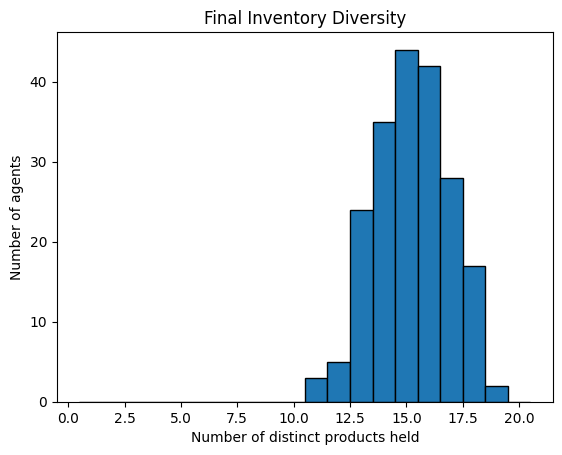

In [162]:
#Run the simulation and see how long it takes to run and see if products get distributed

start = tt.perf_counter()
I_history, T_history, Frac, Trade_history, Demand_list, Agents_score = Trade_Sim(0.5, 1, 1)
print(tt.perf_counter() - start)
#Unique products held by each agent
distinct_products = np.sum(I_history[t_max-1] > 0, axis=1)
plt.hist(distinct_products, bins=range(1, L+2), align='left', edgecolor='black')
plt.xlabel("Number of distinct products held")
plt.ylabel("Number of agents")
plt.title("Final Inventory Diversity")
plt.show()


In [4]:
### 3D plot of individual agent preformance

# Create a figure
fig = go.Figure()

# Create time values
time = np.arange(t_max)

# Add traces for each agent
for i in range(N):
    fig.add_trace(go.Scatter3d(
        x=time, 
        y=np.full_like(time, i),  # Agent index
        z=Agents_score[:, i], 
        mode='lines',
        name=f'Agent {i+1}'
    ))

# Update layout
fig.update_layout(
    scene=dict(
        xaxis_title='Time',
        yaxis_title='Agent Index',
        zaxis_title='Score'
    ),
    title='Agent Scores Over Time',
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the interactive plot
fig.show()

NameError: name 'Agents_score' is not defined

Plotting data for product 0
Plotting data for product 1
Plotting data for product 2
Plotting data for product 3
Plotting data for product 4
Plotting data for product 5
Plotting data for product 6
Plotting data for product 7
Plotting data for product 8
Plotting data for product 9
Plotting data for product 10
Plotting data for product 11
Plotting data for product 12
Plotting data for product 13
Plotting data for product 14
Plotting data for product 15
Plotting data for product 16
Plotting data for product 17
Plotting data for product 18
Plotting data for product 19


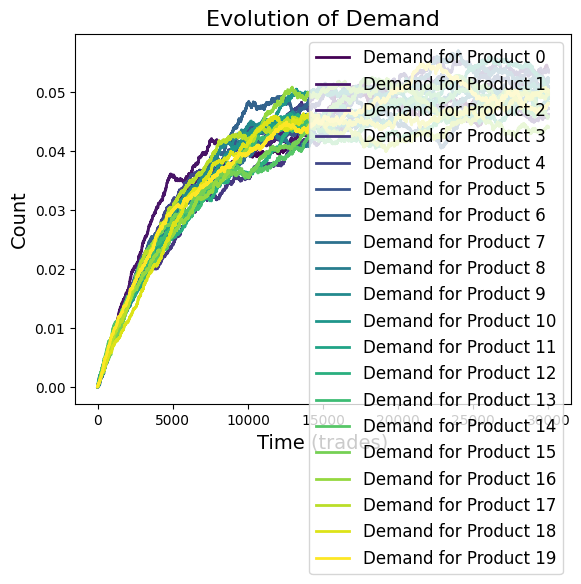

In [163]:
### Eveloution of Demand plotted for each product

# Use a colormap for different colors
colors = plt.cm.viridis(np.linspace(0, 1, L))
#I_A = np.sum(I_history[0], axis = 0)
#plt.axhline(1/L, linestyle='-', label =f"Equal Amount of product", color="red")
for p in range(L):
    print(f"Plotting data for product {p}")
    plt.plot( Demand_list[:,p], label=f'Demand for Product {p}', lw=2, color=colors[p])
    #plt.axhline(I_A[p]/(N*U), linestyle='-', label =f"Product {p}", color=colors[p])
    #print(f"Amount pr. Agent = {I_A[p]/N}")
    
plt.xlabel('Time (trades)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title(f'Evolution of Demand', fontsize=16)
plt.legend(fontsize=12)
plt.show()

Plotting data for product 0
Plotting data for product 1
Plotting data for product 2
Plotting data for product 3
Plotting data for product 4
Plotting data for product 5
Plotting data for product 6
Plotting data for product 7
Plotting data for product 8
Plotting data for product 9


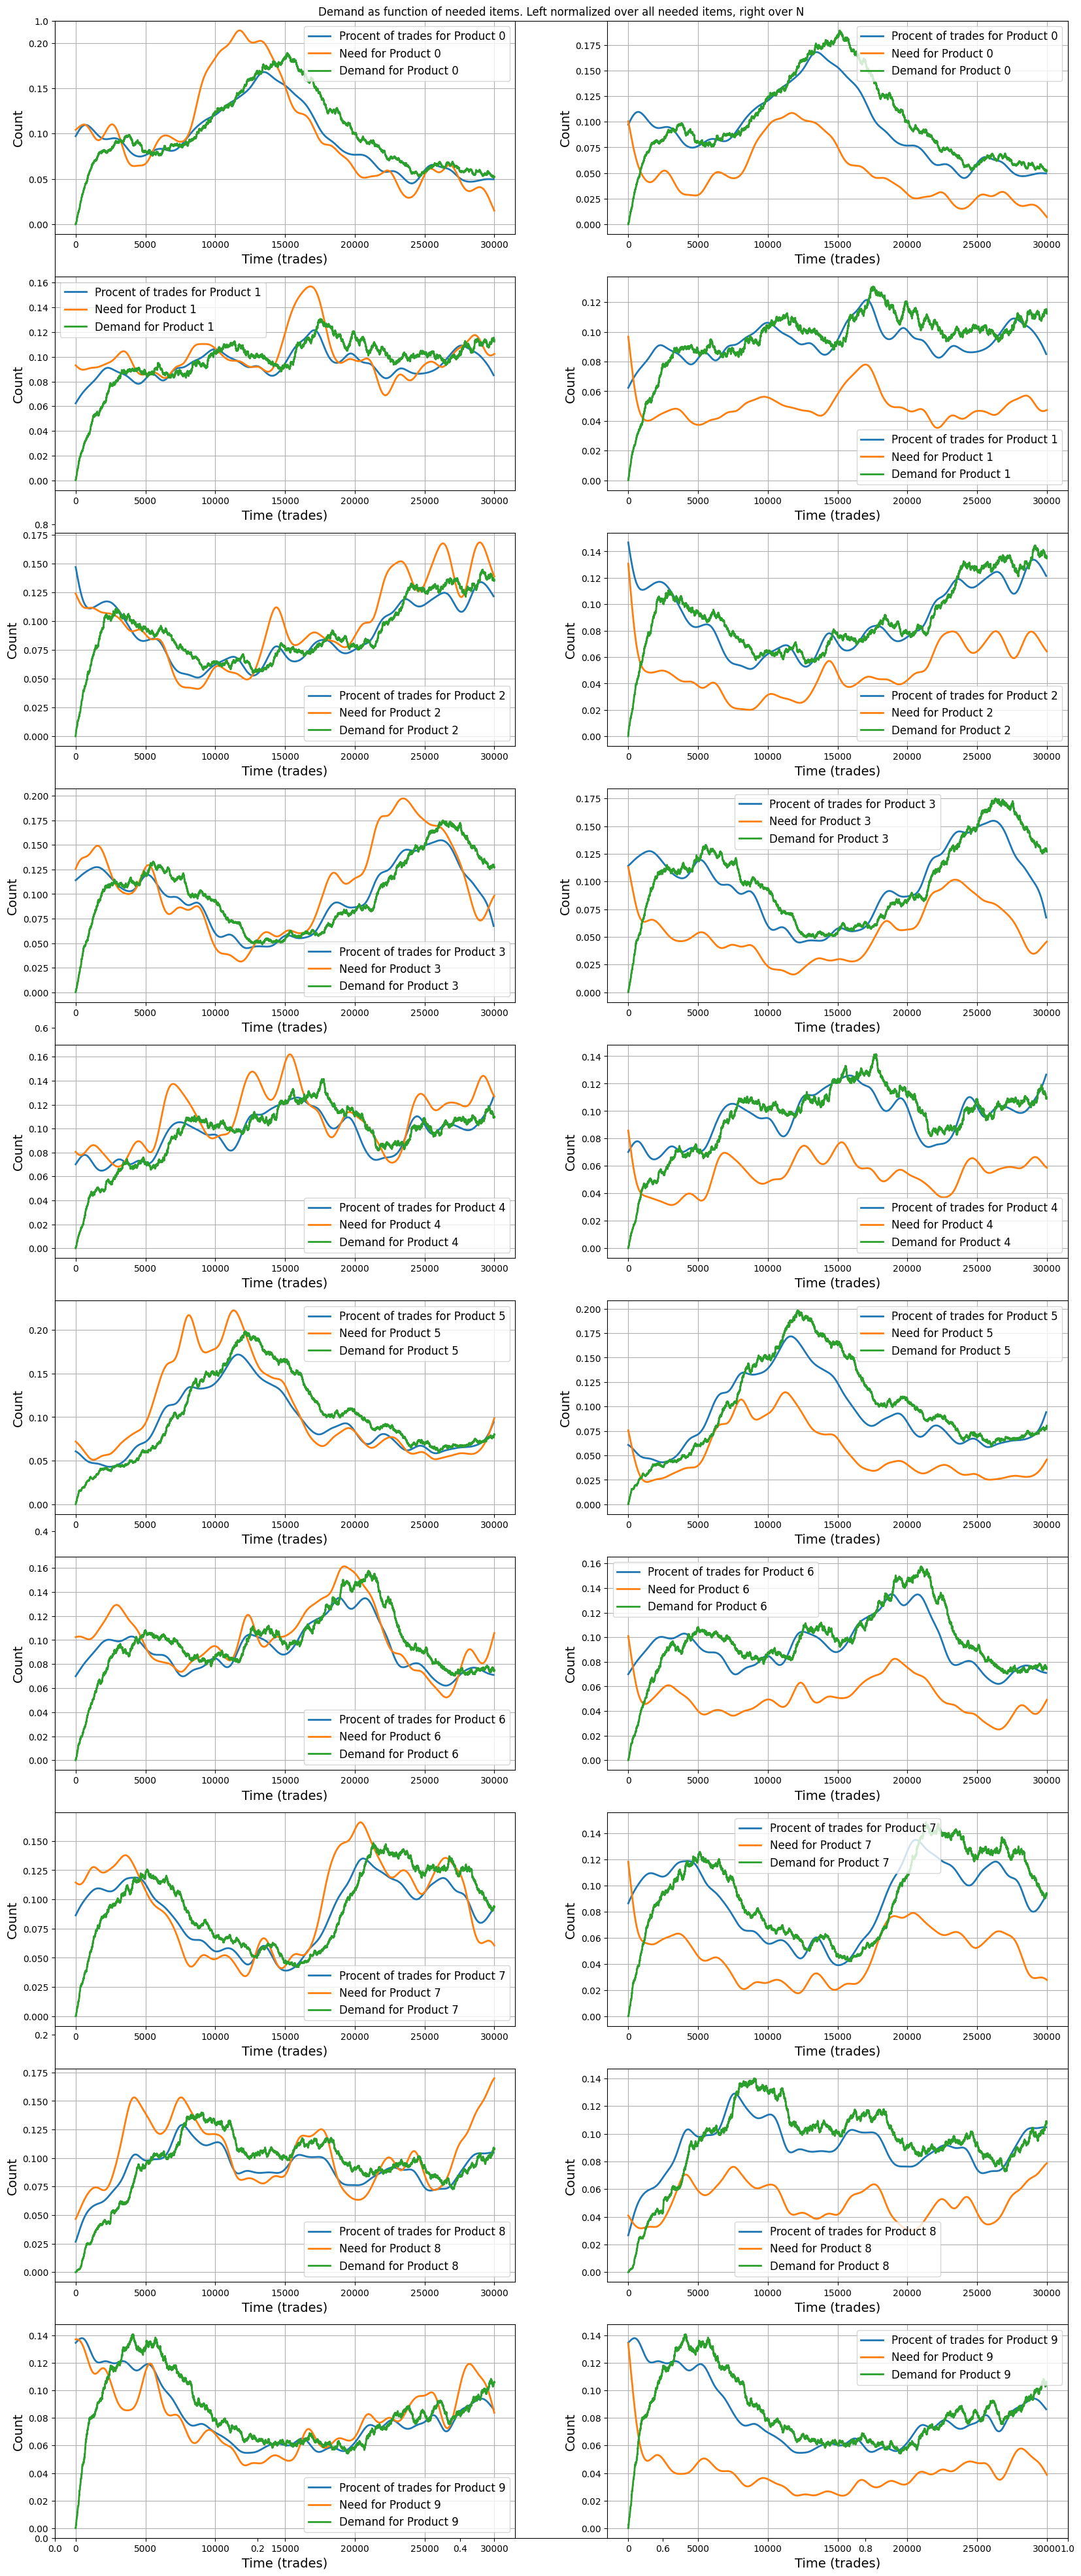

In [147]:
### Analyze each individual product

# --- Choose a random product ---
Trades = count_elements_in_chunks(Trade_history, t_max, L)
plt.figure(figsize=(20,L*10))
plt.title("Demand as function of needed items. Left normalized over all needed items, right over N")
for p in range(L):
    print(f"Plotting data for product {p}")
    # --- Preallocate arrays for time series ---
    needed_items = np.zeros((t_max, L))
    #monetary_value = np.zeros(t_max)
    
    # --- Compute time series ---
    for t in range(t_max):
        # Total stock: sum over all agents of product p in their inventory.
        #total_stock[t] = I_history[t, :, p].sum()
        
        
        needed_items[t] = np.sum(I_history[t] == 0,axis=0)

    # Use scatter plot with a colormap to show time progression
    #plt.plot(total_stock, label=f'Total Stock of Product {p}', lw=2)
    plt.subplot(L,2,p*2+1)
    temp = needed_items[:,p]/np.sum(needed_items, axis = 1)
    temp3 = ski.filters.gaussian(Trades[:,p]/100,sigma=10)
    plt.plot(Trades[:,L],temp3, label = f"Procent of trades for Product {p}", lw = 2)
    plt.plot(ski.filters.gaussian(temp,sigma=(500)), label=f'Need for Product {p}', lw=2)
    plt.plot(Demand_list[:,p], label=f'Demand for Product {p}', lw=2)
    #plt.plot(monetary_value, label=f'Monetary Value for Product {p}', lw=2)
    plt.xlabel('Time (trades)', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    #plt.title(f'Evolution of Demand for Product {p}', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.subplot(L,2,p*2+2)
    temp2 = needed_items[:,p]/N
    
    plt.plot(Trades[:,L],temp3, label = f"Procent of trades for Product {p}", lw = 2)
    plt.plot(ski.filters.gaussian(temp2,sigma=(500)), label=f'Need for Product {p}', lw=2)
    plt.plot(Demand_list[:,p], label=f'Demand for Product {p}', lw=2)
    
    #plt.plot(monetary_value, label=f'Monetary Value for Product {p}', lw=2)
    plt.xlabel('Time (trades)', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    #plt.title(f'Evolution of Demand for Product {p}', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
plt.savefig('Demand vs Need - With only Greed.png')
plt.show()

0.0009965635738831617


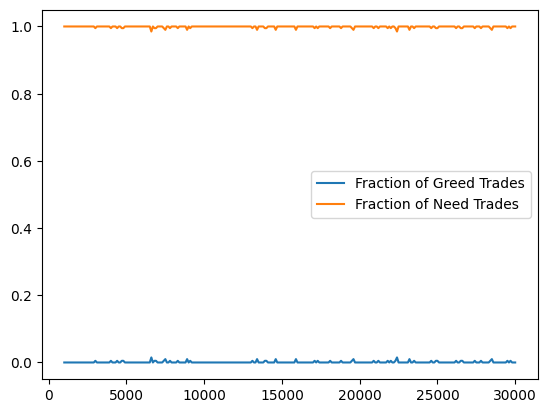

In [164]:
### Analyze fraction of need and greed trades

Frac_hist = Frac[10:, :]
plt.plot(Frac_hist[:,0]*100, Frac_hist[:,1], label = "Fraction of Greed Trades")
plt.plot(Frac_hist[:,0]*100, Frac_hist[:,2], label = "Fraction of Need Trades")
plt.legend()
print(np.mean(Frac_hist[:,1]))
plt.show()

In [20]:
### Analyse fraction of need and greed trades based on based on U/L ratio

N = 100
t_max = 5001
L = 10
M = 30
Frac_NeedGreed = np.zeros((200, 2))
for U in range(1,201):
    U = U
    I_history, T_history, Frac_hist, Trade_history, Demand_list = Trade_Sim(0,1,1)
    Frac_NeedGreed[U-1, 0] = np.mean(Frac_hist[10:50,1])
    Frac_NeedGreed[U-1, 1] = np.mean(Frac_hist[10:50,2])

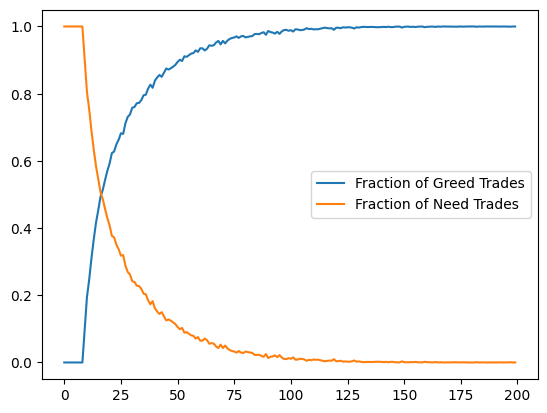

In [21]:
plt.plot(Frac_NeedGreed[:,0], label = "Fraction of Greed Trades")
plt.plot(Frac_NeedGreed[:,1], label = "Fraction of Need Trades")
plt.legend()
plt.show()

In [102]:
### Stochastic analysis of hurst exponent

N = 100
t_max = 30000
L = 10
M = 40
U = 11
Frac_NeedGreed = np.zeros((10, 2))
Hurst_exponent_average = np.zeros(10)
timer = 8
index = 0
M_list = [5, 10, 15, 20, 30, 40, 60, 70, 80, 100]
for M in M_list:
    M = M
    I_history, T_history, Frac_hist, Trade_history, Demand_list, Acent_score = Trade_Sim(0,1,1)
    Frac_NeedGreed[round(index), 0] = np.mean(Frac_hist[10:,1])
    Frac_NeedGreed[round(index), 1] = np.mean(Frac_hist[10:,2])
    Slope_list = []

    for p in range(L):
        zero_indices = np.where(Demand_list[15000:, p] == 0)[0]  # Find zero indices after index 1000
    
        if zero_indices.size > 0:
            first_zero_after_1000 = zero_indices[0] + 15000  # Get the first zero index and adjust for offset
        else:
            first_zero_after_1000 = Demand_list.shape[0]  # If no zero is found, use the full length
    
        # Slice the array up to that index
        arr = Demand_list[10000:first_zero_after_1000, p]
        Temp2 = []
        TL = [1,5, 10, 50, 100, 500]
        for T in TL:
            Temp2.append(Hurst(arr,T))
        # Take the logarithm
        log_TL = np.log(TL)
        log_Temp2 = np.log(Temp2)
        
        # Perform linear regression (1st-degree polynomial fit)
        slope, intercept = np.polyfit(log_TL, log_Temp2, 1)
        
        # Generate fitted values
        fitted_values = slope * log_TL + intercept
        '''
        # Plot data and regression line
        plt.scatter(log_TL, log_Temp2, label="Data", color='blue')
        plt.plot(log_TL, fitted_values, label=f"Fit: y = {slope:.3f}x + {intercept:.3f}", color='red')
        plt.xlabel("log(TL)")
        plt.ylabel("log(Temp2)")
        plt.title("Log-Log Linear Regression")
        plt.legend()
        plt.grid()
        plt.show()
        '''
        # Print results
        #print(f"Slope (exponent): {slope}")
        #print(f"Intercept: {intercept}")
        if isinstance(slope, (int, float)) and not math.isnan(slope):
            Slope_list.append(slope)
    Hurst_exponent_average[index] = np.mean(Slope_list)
    timer -= 1
    index += 1
    print(timer)

7
6
5
4
3
2
1
0
-1
-2


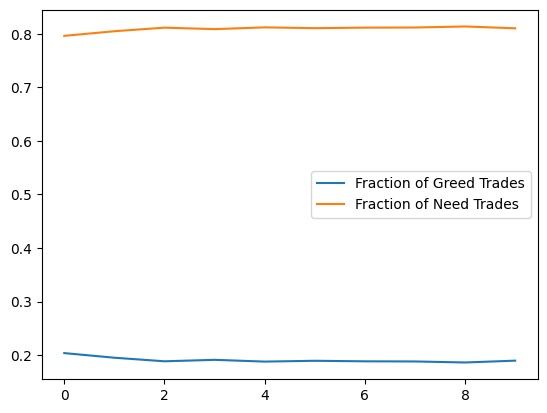

In [103]:
plt.plot(Frac_NeedGreed[:,0], label = "Fraction of Greed Trades")
plt.plot(Frac_NeedGreed[:,1], label = "Fraction of Need Trades")
plt.legend()
plt.show()

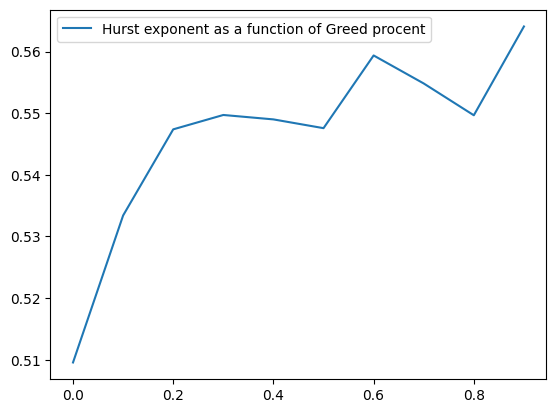

In [104]:
plt.plot(np.arange(0,1, 0.1), Hurst_exponent_average/2, label = "Hurst exponent as a function of Greed procent")
plt.legend()
plt.show()

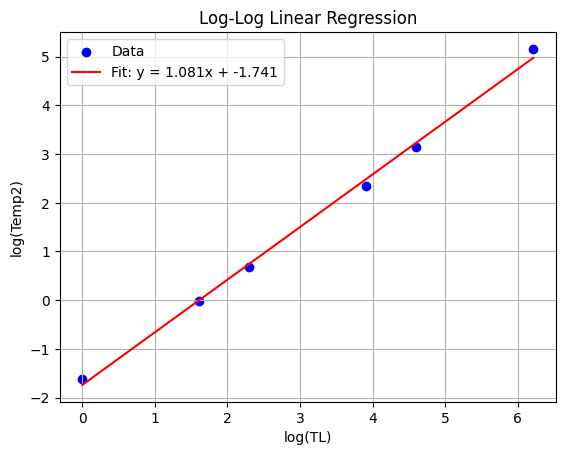

Slope (exponent): 1.0808565976017712


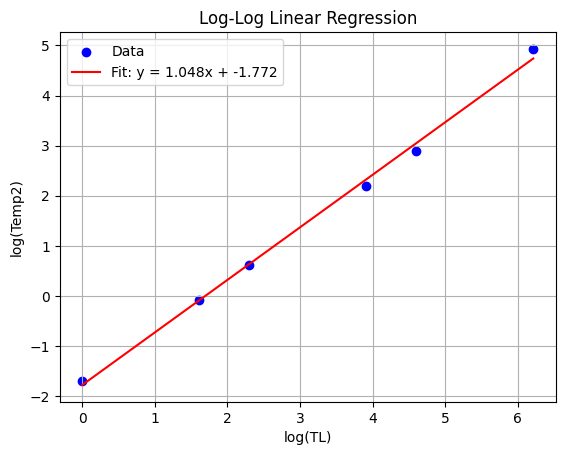

Slope (exponent): 1.0475398081073022


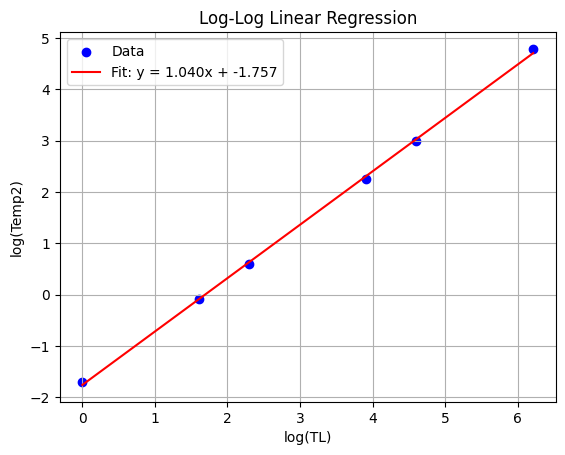

Slope (exponent): 1.0402718778736226


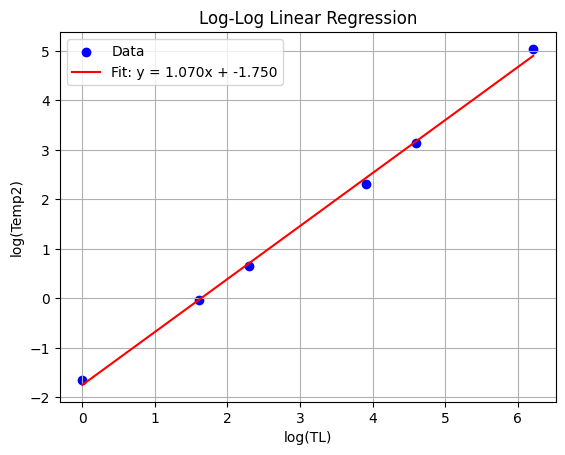

Slope (exponent): 1.0702893674359368


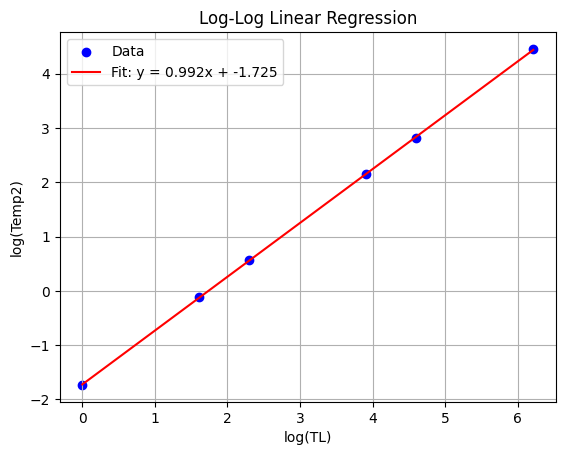

Slope (exponent): 0.9920653488728155


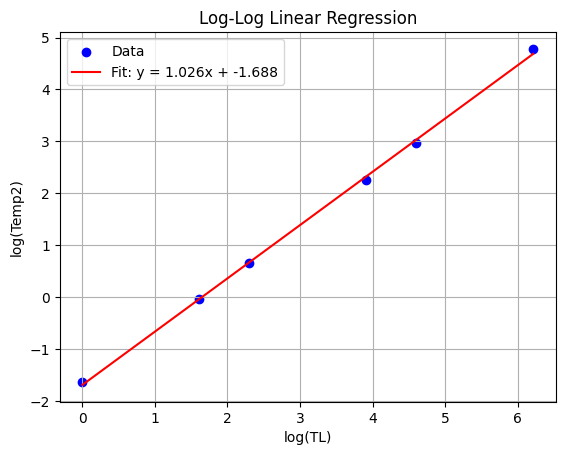

Slope (exponent): 1.025585396833081


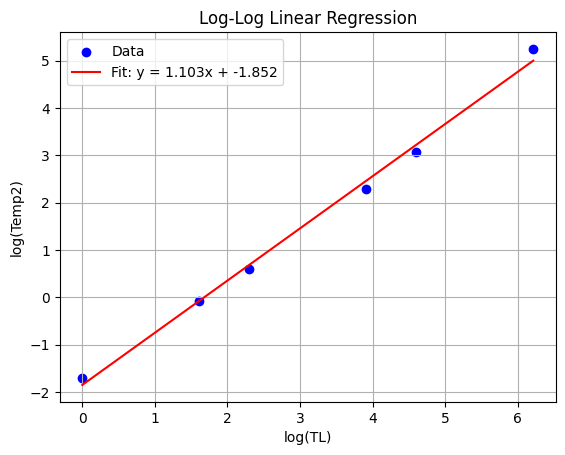

Slope (exponent): 1.1025272712454068


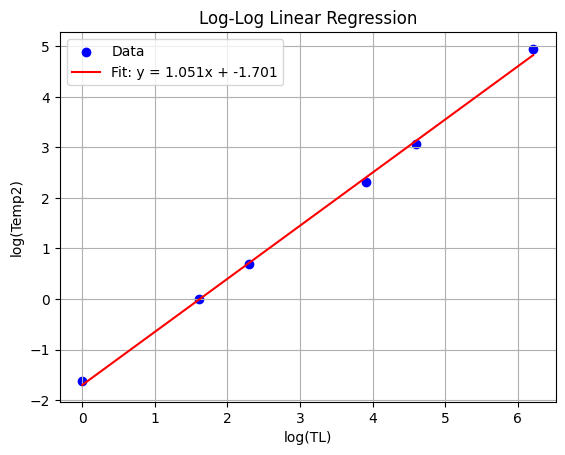

Slope (exponent): 1.0506146425631107


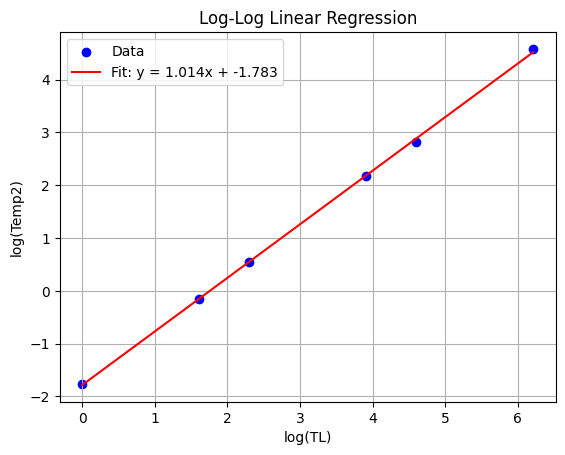

Slope (exponent): 1.014235798940361


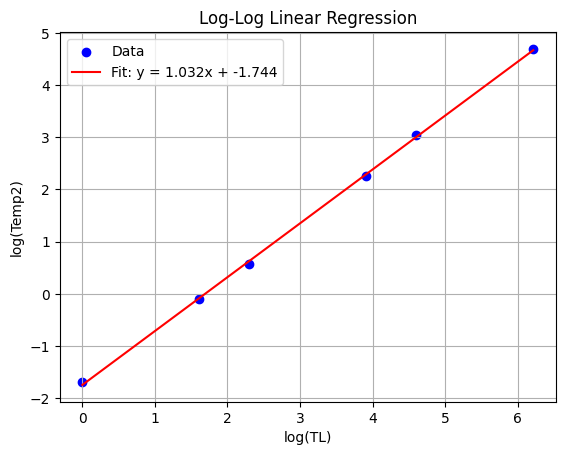

Slope (exponent): 1.0317656162582471


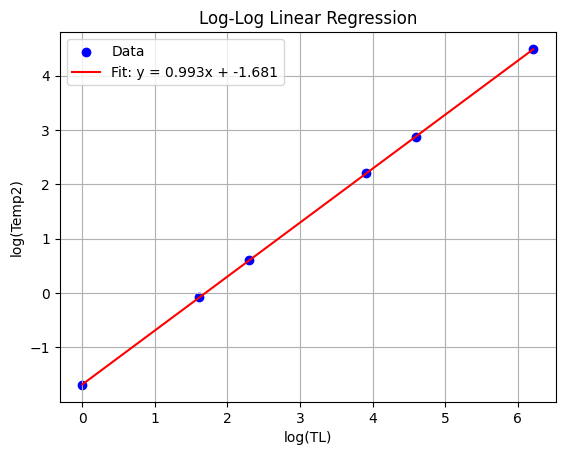

Slope (exponent): 0.992609101913498


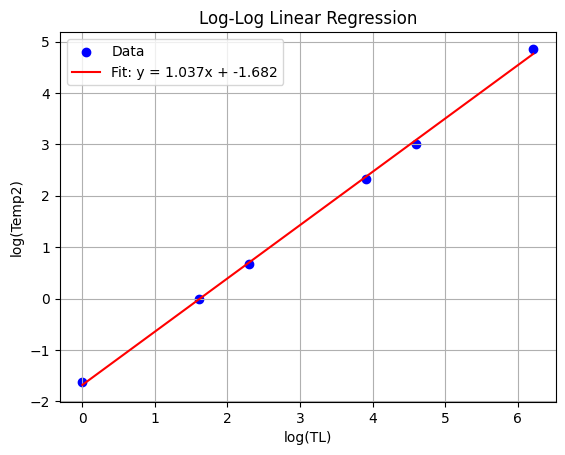

Slope (exponent): 1.036546203029272


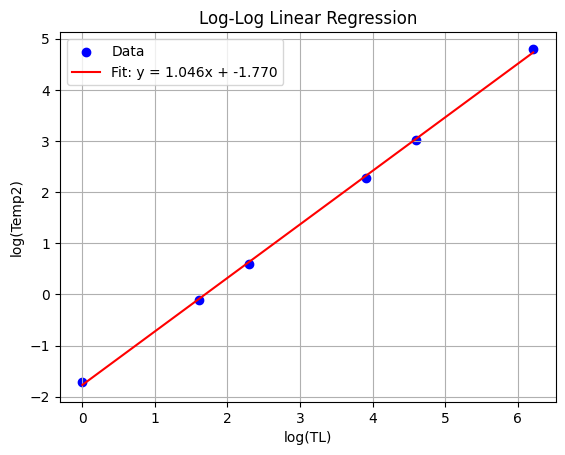

Slope (exponent): 1.0462163982152048


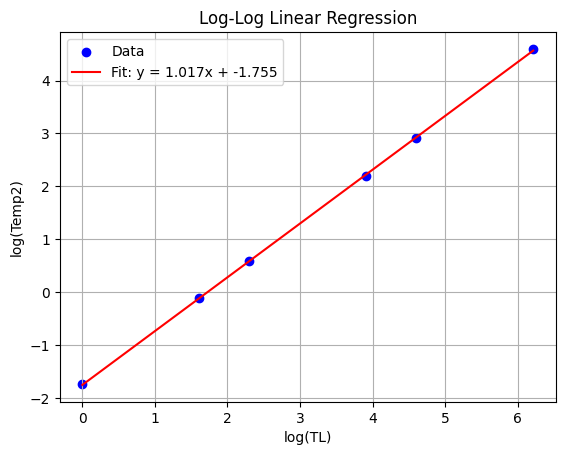

Slope (exponent): 1.0173574712836018


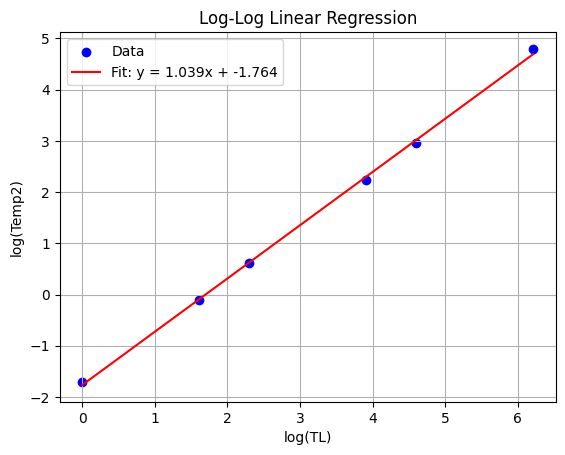

Slope (exponent): 1.0392742599289926


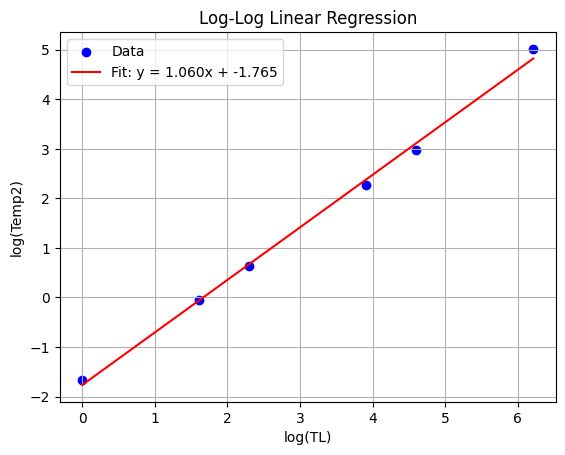

Slope (exponent): 1.0599973952923925


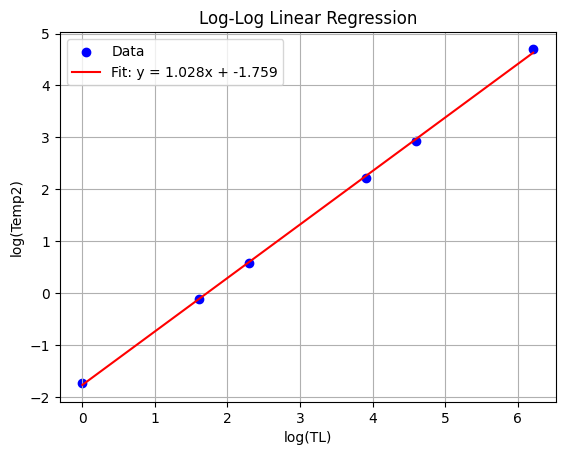

Slope (exponent): 1.0284580082214279


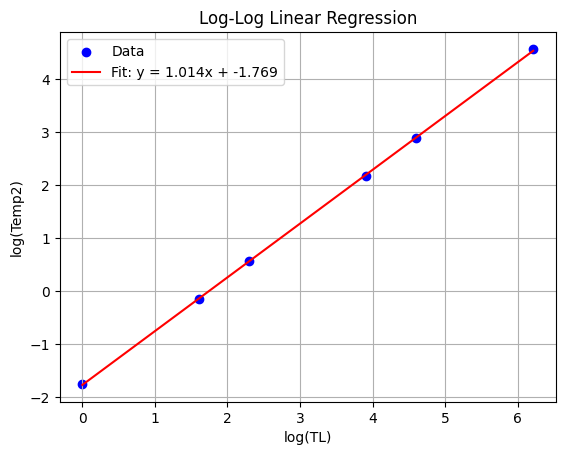

Slope (exponent): 1.0140748293755406


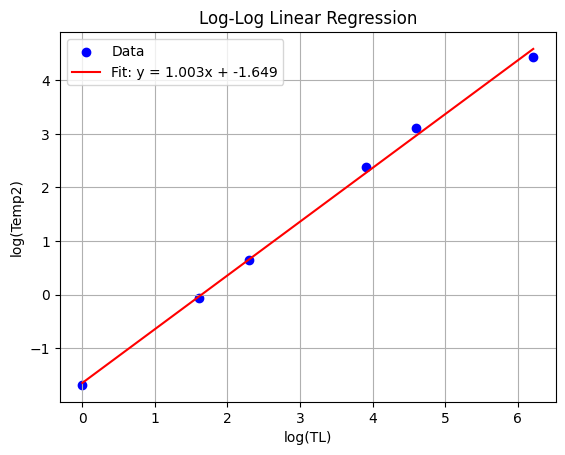

Slope (exponent): 1.0033597637812357


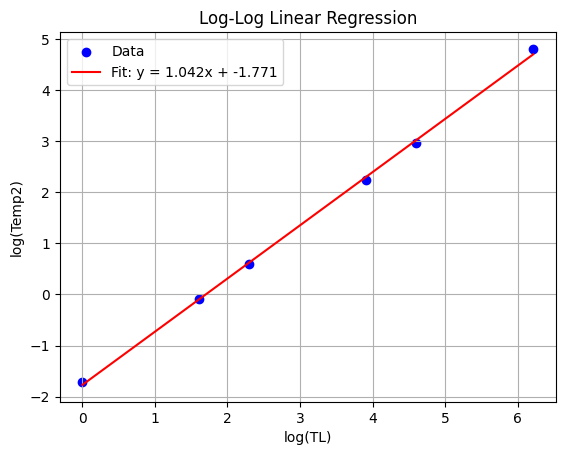

Slope (exponent): 1.0416502097087263


In [165]:
### Calculate Hurst Exponent

slope_average = []
for p in range(L):
        zero_indices = np.where(Demand_list[12000:, p] == 0)[0]  # Find zero indices after index 1000
    
        if zero_indices.size > 0:
            first_zero_after_1000 = zero_indices[0] + 12000  # Get the first zero index and adjust for offset
        else:
            first_zero_after_1000 = Demand_list.shape[0]  # If no zero is found, use the full length
    
        # Slice the array up to that index
        arr = Demand_list[12000:first_zero_after_1000, p]
        Temp2 = []
        TL = [1,5, 10, 50, 100, 500]
        for T in TL:
            Temp2.append(Hurst(arr*(N*M),T))
        # Take the logarithm
        log_TL = np.log(TL)
        log_Temp2 = np.log(Temp2)
        
        # Perform linear regression (1st-degree polynomial fit)
        slope, intercept = np.polyfit(log_TL, log_Temp2, 1)
        
        # Generate fitted values
        fitted_values = slope * log_TL + intercept

        # Plot data and regression line
        plt.scatter(log_TL, log_Temp2, label="Data", color='blue')
        plt.plot(log_TL, fitted_values, label=f"Fit: y = {slope:.3f}x + {intercept:.3f}", color='red')
        plt.xlabel("log(TL)")
        plt.ylabel("log(Temp2)")
        plt.title("Log-Log Linear Regression")
        plt.legend()
        plt.grid()
        plt.show()

        #Print results
        print(f"Slope (exponent): {slope}")

In [49]:
### Stochastic analysis of demand

Stoc_demand = []
for i in range(50):
    
    Demand_123 = np.zeros((L, t_max))
    I_hist, T_hist, Frac_hist, Trades = Trade_Sim(0,1,1)

    demand_sums = []  # To store (sum, demand array, p index)
    
    for p in range(L):
        demand = np.zeros(t_max)
        for t in range(t_max):
            demand[t] = np.sum(T_hist[t] == p)
        
        demand_sums.append((np.sum(demand), demand))  # Store sum along with array

    # Sort by sum in descending order
    demand_sums.sort(reverse=True, key=lambda x: x[0])

    # Assign top 3 demand arrays to Demand_123
    for idx in range(min(L, len(demand_sums))):  # Ensure we don't go out of bounds
        Demand_123[idx] = demand_sums[idx][1]
    
    Stoc_demand.append(Demand_123)
    print(f"{i*2}% done")


0% done
2% done
4% done
6% done
8% done
10% done
12% done
14% done
16% done
18% done
20% done
22% done
24% done
26% done
28% done
30% done
32% done
34% done
36% done
38% done
40% done
42% done
44% done
46% done
48% done
50% done
52% done
54% done
56% done
58% done
60% done
62% done
64% done
66% done
68% done
70% done
72% done
74% done
76% done
78% done
80% done
82% done
84% done
86% done
88% done
90% done
92% done
94% done
96% done
98% done


In [50]:
Stoc_demand = np.array(Stoc_demand)
Avg_demand = np.mean(Stoc_demand, axis=0)

Plotting data for product 0
Plotting data for product 1
Plotting data for product 2


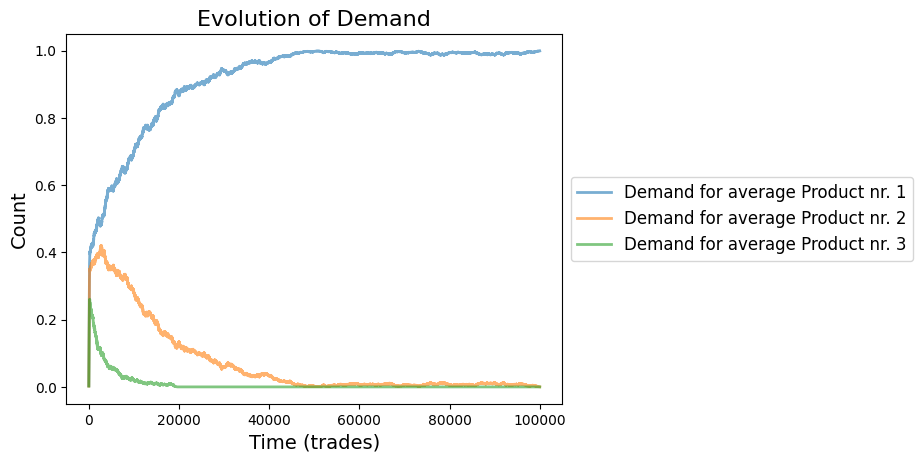

In [51]:

for p in range(L):
    print(f"Plotting data for product {p}")

    plt.plot(Avg_demand[p]/(M*N), label=f'Demand for average Product nr. {p+1}', lw=2, alpha = 0.6)
    
#print(I_hist[t_max-1])
plt.xlabel('Time (trades)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title(f'Evolution of Demand', fontsize=16)
plt.legend(fontsize=12, bbox_to_anchor=(1, 0.5), loc = 6)
plt.show()

C:\Users\lucq0\AppData\Local\Temp\ipykernel_32108\793438156.py:7: RuntimeWarning:

invalid value encountered in scalar divide



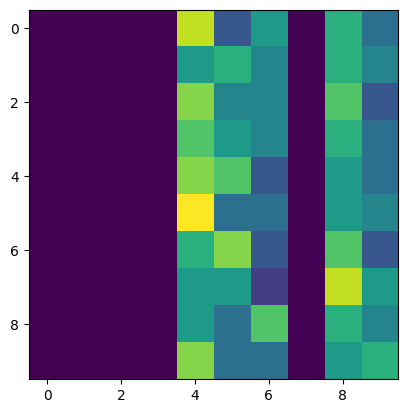

In [43]:
### Memory analysis

T_hist = T_history
Data = np.zeros((t_max,N,L))


for t in range(t_max):
    for n in range(N):
        Data[t][n] = (np.sum(T_hist[t][n] == 0) / (M - np.sum(T_hist[t][n] == -1)),np.sum(T_hist[t][n] == 1) / (M - np.sum(T_hist[t][n] == -1)),np.sum(T_hist[t][n] == 2) / (M - np.sum(T_hist[t][n] == -1)),np.sum(T_hist[t][n] == 3) / (M - np.sum(T_hist[t][n] == -1)),np.sum(T_hist[t][n] == 4) / (M - np.sum(T_hist[t][n] == -1)),np.sum(T_hist[t][n] == 5) / (M - np.sum(T_hist[t][n] == -1)),np.sum(T_hist[t][n] == 6) / (M - np.sum(T_hist[t][n] == -1)),np.sum(T_hist[t][n] == 7) / (M - np.sum(T_hist[t][n] == -1)),np.sum(T_hist[t][n] == 8) / (M - np.sum(T_hist[t][n] == -1)),np.sum(T_hist[t][n] == 9) / (M - np.sum(T_hist[t][n] == -1)))
plt.imshow(Data[-1,:,:])

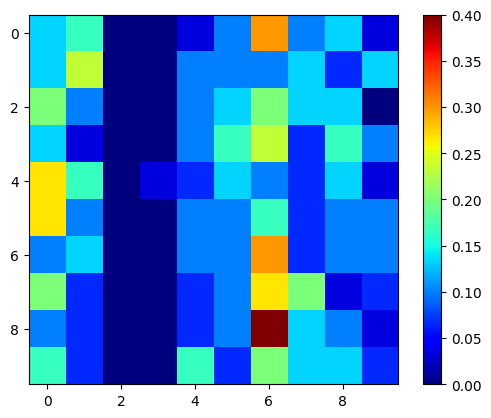

In [44]:
plt.imshow(Data[1000,:,:],cmap="jet")
plt.colorbar()

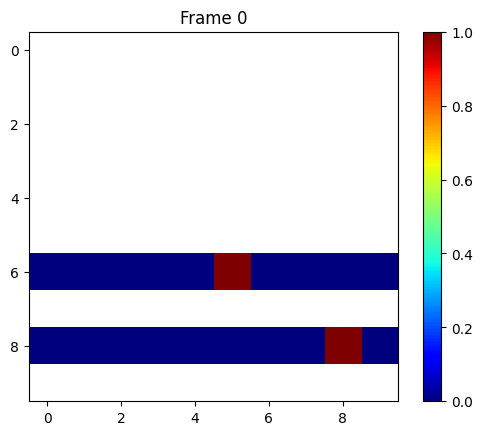

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Parameters
x = 1000  # Change this to select every x-th frame
#fps = 10  # Frames per second for the GIF

# Simulated Data (replace this with your actual Data array)
#T, N, M = 100, 50, 50  # Example dimensions
#Data = np.random.rand(T, N, M)  # Example data

T,N,M = Data.shape

def animate_local(Data, x=1000):
    fig, ax = plt.subplots()
    cax = ax.imshow(Data[0, :, :], cmap="jet")
    plt.colorbar(cax)
    ax.set_title("Frame 0")
    
    def update(t):
        cax.set_data(Data[t, :, :])
        ax.set_title(f"Frame {t}")
        return cax,
    
    ani = animation.FuncAnimation(fig, update, frames=range(0, Data.shape[0], x), interval=100)
    return HTML(ani.to_jshtml())

# Call the function to display animation in Jupyter Notebook
animate_local(Data[:], 500)



In [89]:
T,N,M = Data.shape
stdlist = np.zeros((T,M))
for k in range(T):
    stdlist[k] = np.std(Data[k],axis=0)

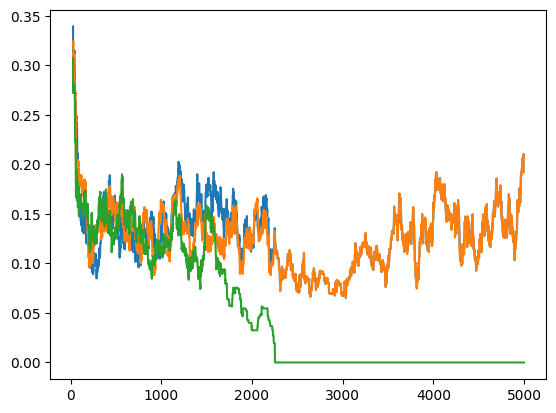

In [90]:
Len = 5000
plt.plot(np.arange(Len),stdlist[:Len,:])